# Lab 04
# GloVe implementation of a sentiment analysis model

## Adrien Giget, Tanguy Malandain, Denis Stojiljkovic

# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
from copy import deepcopy
from functools import partial
from typing import Callable, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [2]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [3]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [4]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [5]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [6]:
%%time

word = "cat"
#  Find the closest word to "cat" in the whole vocabulary

test_value = 0
closest_word = None
for w in glove.stoi:
    if w == word:
        continue

    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[w]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()

    if similarity > test_value:
        test_value = similarity
        closest_word = w

print(f"{words[0]} x {closest_word} = {test_value}")

cat x dog = 0.6816746592521667
CPU times: total: 12.5 s
Wall time: 13.8 s


cat x dog = 0.6816746592521667 : on remarque que vis à vis du GloVe, le mot qui est le plus proche de cat, si l'on échange dans une phrase garde un sens le plus similaire sémantiquement, est dog.

## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [7]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [8]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [9]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    # 1. Tokenize the text.
    tokens = tokenizer(text)

    # 2. Get the vectors for each token.
    vectors = [vocabulary.vectors[vocabulary.stoi[token]] for token in tokens if token in vocabulary.stoi]

    # 3. Average them.
    return torch.mean(torch.stack(vectors), dim=0)


In [10]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [11]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:20<00:00, 1204.39it/s]


### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [12]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)

    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i:i+batch_size]), torch.tensor(y[i:i+batch_size])

In [13]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [14]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int, *args, **kwargs) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(embedding_size, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.linear(x)

## Training (3 points)

We put everything above together and train the classifier.

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [17]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [18]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()

    # training loop
    train_loss = 0.0
    for X, y in train_gen():
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y.unsqueeze(1).float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(X_train)
    train_losses.append(train_loss)

    # validation
    model.eval()

    # validation loop
    with torch.no_grad():
        valid_loss = 0.0
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y.unsqueeze(1).float())
            valid_loss += loss.item()

        valid_loss /= len(X_valid)
        valid_losses.append(valid_loss)

    # save the best model
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        best_model = deepcopy(model)



100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


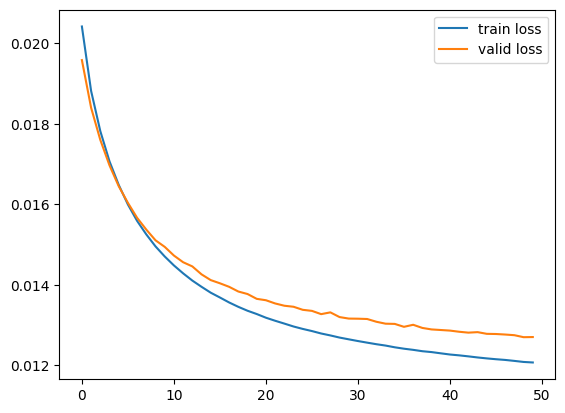

In [19]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

Le résultat semble cohérent et plutôt bon.

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [20]:
def compute_accuracy(model: nn.Module, data_gen: Callable[[], Generator]) -> float:
    """
    Compute the accuracy of the model on the given data.
    :param model: the model to evaluate : nn.Module
    :param data_gen: a generator function returning batches of data : Callable[[], Generator]
    :return: the accuracy : float
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_gen():
            X, y = X.to(device), y.to(device)
            logits = model(X)
            predictions = torch.round(torch.sigmoid(logits))
            correct += (predictions == y.unsqueeze(1)).sum().item()
            total += len(y)

    return correct / total

print(f"Training accuracy: {compute_accuracy(model, train_gen):.4f}")
print(f"Validation accuracy: {compute_accuracy(model, valid_gen):.4f}")
print(f"Test accuracy: {compute_accuracy(model, test_gen):.4f}")

Training accuracy: 0.8349
Validation accuracy: 0.8280
Test accuracy: 0.8253


**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**


On réutilise et adapte la fonction `get_wrongly_classified` définie dans le lab précédant.

In [21]:
def get_wrongly_classified(model: nn.Module, data_gen: Callable[[], Generator]) -> List[Tuple[str, int, float]]:
    """
    Get the wrong predictions of the model on the given data.
    :param model: the model to evaluate : nn.Module
    :param data_gen: a generator function returning batches of data : Callable[[], Generator]
    :return: a list of tuples (text, label, score) : List[Tuple[str, int, float]]
    """
    model.eval()
    wrong_predictions = []

    with torch.no_grad():
        index = 0
        for X, y in data_gen():
            X, y = X.to(device), y.to(device)
            predictions = torch.round(torch.sigmoid(model(X)))
            wrong_predictions += [
                (text, int(label), index)
                for text, label, prediction in zip(X_test, y, predictions)
                if prediction != label
            ]
            index += 1

    return wrong_predictions

wrong_classified = get_wrongly_classified(model, test_gen)
print(f"Number of wrong predictions: {len(wrong_classified)}")

Number of wrong predictions: 4368


In [22]:
# instantiate a Pseudo-random number generator (PRNG)
rng = np.random.default_rng(420)

In [23]:
infos_1 = wrong_classified[int(rng.random() * len(wrong_classified))]
print(f"Correct label : {infos_1[1]}\nText: \n{test_df['text'][infos_1[2]]}")

Correct label : 0
Text: 
The 1935 version of "Enchanted April" manages to be simultaneously tedious<br /><br />and perfunctory. It is difficult to show the transformative magic of Italy shooting in a studio with only stereotypical Italian behavior to belabor. The transformation of the four strangers fleeing London is instantaneous in the cut from the first day to a week later. Rather than develop, the screenplay flips a switch and the<br /><br />characters are different.<br /><br />The husbands are boring enough in flashbacks without turning up, even if their presence does not drive the four women back into their shells and/or hostilities.<br /><br />Jessie Ralph has the most fun (moving instead of entirely chewing up the<br /><br />scenery) and Katharine Alexander has some poignant charm out of her<br /><br />husband's shadow (and away from his hideous droning). Ann Harding is<br /><br />unremarkable here (with the Production Code being enforced). She had an<br /><br />appropriate lin

On peut expliquer l'erreur parce que l'auteur fait une critique en utilisant peu de phrases négatives. De plus, l'auteur construit une argumentation, il donne donc des points positifs et négatifs pour analyser ce film. (Pos: "Jessie Ralph has the most fun" ou "Katharine Alexander has some poignant charm". Neg : "only look hurt, rush out"). Ceci a pu induire le modèle en erreur.

In [24]:
infos_2 = wrong_classified[int(rng.random() * len(wrong_classified))]
print(f"Correct label : {infos_2[1]}\nText: \n{test_df['text'][infos_2[2]]}")

Correct label : 0
Text: 
Ho humm - - - More of nothing. If you are a long-time Rush fan you know what this video contains: loathsome songs from the past, the "BIG 3" hits from the 80's and their "last-ditch" efforts to remain contemporary. They do succeed in making fun of themselves by beating the critics to the punch by portraying themselves as "dinosaurs." Unfortunately, they FAIL at protecting themselves from embarrassment. Close-ups of their faces only add to the fact that these guys HAVE BEEN.<br /><br />If you are have been following (as much as you can stomach) the band for a couple of decades from the 70's, then you know there is no new material here. Same old, same OLD: 1) Neil avoids the press, 2) no real behind-the-scenes (Geddy looses his SHOES?! Give me a break! Even HE thinks it's absurd!) 3) no new insights.<br /><br />A better video would have been to show the CREW setting up for 3 or 4 hours  just let the camera run. And stop changing camera angles every 2 seconds! I 

Bien que le commentaire exprime clairement des critiques et des déceptions à l'égard du contenu de la vidéo, il peut ne pas contenir suffisamment de marqueurs émotionnels forts, tels que des mots forts ou des expressions émotionnelles explicites, pour indiquer clairement une tonalité négative au modèle. Le commentaire utilise des phrases complexes et des négations, ce qui peut rendre la tonalité générale difficile à interpréter. Par exemple, la phrase "Unfortunately, they FAIL at protecting themselves from embarrassment" peut sembler négative à première vue, mais elle peut être mal comprise si le modèle ne prend pas en compte le contexte global.

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [26]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    model.eval()
    X = text_pipeline(text).to(device)
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        return int(torch.round(probs)), float(probs)

In [27]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

(0, 0.32509440183639526)

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.

In [28]:
class MLPPerceptron(nn.Module):
    """
    A two-layer multilayer perceptron.
    """

    def __init__(self, embedding_size: int, nb_classes: int, hidden_size : int = 128, *args, **kwargs) -> None:
        """
        :param embedding_size: the dimension of the input embeddings : int
        :param nb_classes: the output dimension : int
        :param hidden_size: the size of the hidden layer : int
        """
        super().__init__(*args, **kwargs)
        self.linear1 = nn.Linear(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, nb_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: an input tensor: torch.Tensor
        :return: the logits: torch.Tensor
        """
        x1 = self.relu(self.linear1(x))
        return self.linear2(x1)

In [29]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [30]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

In [31]:
model = MLPPerceptron(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):
    # training
    model.train()

    # training loop
    train_loss = 0.0
    for X, y in train_gen():
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y.unsqueeze(1).float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(X_train)
    train_losses.append(train_loss)

    # validation
    model.eval()

    # validation loop
    with torch.no_grad():
        valid_loss = 0.0
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y.unsqueeze(1).float())
            valid_loss += loss.item()

        valid_loss /= len(X_valid)
        valid_losses.append(valid_loss)

    # save the best model
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        best_model = deepcopy(model)

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


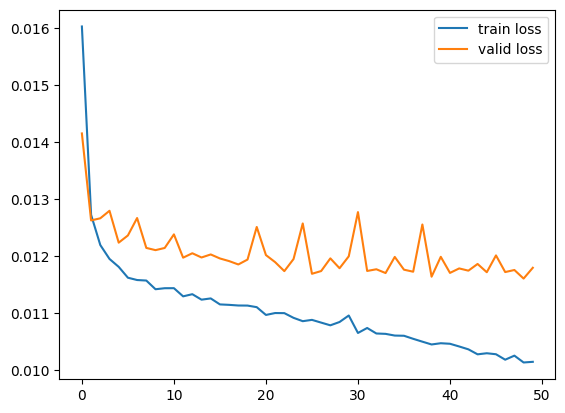

In [32]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

In [33]:
print(f"Training accuracy: {compute_accuracy(model, train_gen):.4f}")
print(f"Validation accuracy: {compute_accuracy(model, valid_gen):.4f}")
print(f"Test accuracy: {compute_accuracy(model, test_gen):.4f}")

text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

Training accuracy: 0.8629
Validation accuracy: 0.8404
Test accuracy: 0.8418


(0, 0.2466152310371399)